In [1]:
# import all modules required
import numpy as np              # for the arrays  
import matplotlib.pyplot as plt # for the plotting
import scipy.integrate as si    # to integrate numerically the equations of motion
import scipy.optimize as so     # for the bisection algorithm
# change to qt for plots in a new window
%matplotlib qt

ImportError: Failed to import any qt binding

### Parameters (spring)

In [2]:
# mass of squash ball
m = 0.025 # kg

# diameter of squash ball
d =  0.040 # mm

# mass of carrier
mc = 0.025 # kg

# mass of ball + carrier
mt = m + mc

# Number of springs in series
Ns = 1

# Number of springs in parallel
Np = 1

# Length of spring
L0 = 0.1016 * Ns # m

# Spring constant
k = 794/Ns*Np # N/m
# maximumum compression distance = 0.082 m

# Launch angle
theta = 67/180*np.pi # rad
count=1

# Gravitational acceleration
g = 9.81 # m/s^2

# Friction factor
f = 0.5 # N/(m/s)

# Spring position
xs = 0.2 # m
ys = 0.1 # m

### Parameters (Trajectory)

In [3]:
# density and dynamic viscosity of air
rho = 1.1644    # kg/m^3 (at 30 degree Celsius)
mu  = 1.86e-5 # Pa s (at 30 degree Celsius)

### Initial Conditions for spring

In [4]:
# Initial spring compression
s0 = 0.02 # m

# Initial velocity
v0 = 0.0 # m/s

y0 = [s0, v0]

### Spring equation

In [5]:
# Spring equation
def spring(y, t):
    # unpack
    s, v = y
    # dsdt
    dsdt = -v
    # dvdt
    dvdt = k*s/mt - g*np.sin(theta) - f*v/mt
    
    return dsdt, dvdt

### Find maximum launching velocity

In [6]:
def maxVelocity(t_end):
    t = np.linspace(0, t_end, 100)
    sol = si.odeint(spring, y0, t)
    v, a = spring(sol[-1], t_end)
    return a

[5.268782971501959, 7.047521268926012, 8.82625957473183]


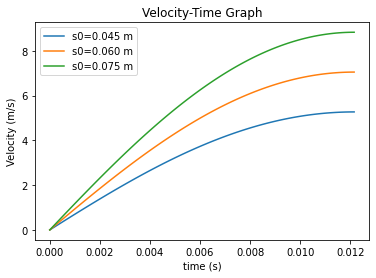

In [7]:
plt.clf()
plt.figure(1)
y = []
for s0 in np.array([0.045,0.060,0.075])*Ns:
    y0 = [s0, v0]

    t_end = so.newton(maxVelocity, 0.013)

    t = np.linspace(0,t_end,100)

    sol = si.odeint(spring, y0, t)

    s = sol[:,0]
    v = sol[:,1]
    
    y.append(v[-1])
    plt.plot(t, v, label='s0=%0.3f m' % s0)
    
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity-Time Graph')

plt.savefig('Velocity-Time Graph', dpi= 1000)

print(y)

### Define functions/equations that needed for trajectory

In [8]:
# obtain drag coefficient from Reynolds number
def get_CD(Re):
    return 24/Re * (1 + 0.27*Re)**0.43 + 0.47 * (1 - np.exp(-0.04*Re**0.38))

In [9]:
# compute right hand side of governing equations at a generic
# position u, defining the x, y, Vx and Vy state variables
def squashball(u, t):
    # unpack u
    x, y, Vx, Vy = u
    
    # find theta
    theta = np.arctan2(Vy, Vx)
    
    # magnitude of velocity
    V_mag = np.sqrt(Vx**2 + Vy**2)
    
    # compute Reynolds number
    Re = rho * V_mag * d / mu
    
    # drag coefficient
    CD = get_CD(Re)
    
    # calculate drag 
    D_mag = 0.5 * rho * V_mag**2 * CD * d**2
    
    # calculate drag components
    Dx = D_mag * np.cos(theta)
    Dy = D_mag * np.sin(theta)
    
    # calculate acceleration
    ax = - Dx/m
    ay = - Dy/m - g
    
    # return velocity and acceleration
    return [Vx, Vy, ax, ay]

### Trajectory 

In [10]:
# return t, x, y, Vx, Vy given final integral time T
def trajectory(x0, y0, Vx0, Vy0, T=1):
    # pack IC into u0
    u0 = [x0, y0, Vx0, Vy0]
    
    # define array of times
    t  = np.linspace(0, T, 101)
    
    # integrate forward
    out = si.odeint(squashball, u0, t)

    # unpack data
    x  = out[:, 0]
    y  = out[:, 1]
    Vx = out[:, 2]
    Vy = out[:, 3]
    
    return t, x, y, Vx, Vy

### Trajectory with stop 

In [11]:
# return t, x, y, Vx, Vy from given IC with y[-1] = 0
def trajectory_with_stop(x0, y0, Vx0, Vy0):

    # return y at t=T from give initial conditions
    def find_y_at_T(T):
        t, x, y, Vx, Vy = trajectory(x0, y0, Vx0, Vy0, T=T)
        return y[-1]
    
    # find T_stop such that y(T_stop) = 0
    # find T_stop such that find_y_at_T(T_stop) = 0
    T_stop = so.newton(find_y_at_T, 2)
    
    return trajectory(x0, y0, Vx0, Vy0, T=T_stop)

### Define functions for calculating distance

In [27]:
# compute velocity components from velocity magnitude and angle
def mag2comp(V_mag, theta):
    return V_mag * np.cos(theta), V_mag * np.sin(theta)

def init_pos(theta):
    
    posx=0.4*np.cos(theta)-0.075
    posy=0.4*np.sin(theta)+0.03
    return posx,posy

In [28]:
# return distance given initial velocity
def distance(V_mag, theta):
    # find velocity components
    theta=theta/180*np.pi
    Vx, Vy = mag2comp(V_mag, theta)

    init_x, init_y= init_pos(theta)
    # solve forward with initial position (with standard of 45 degrees)when launching
    t, x, y, Vx, Vy = trajectory_with_stop(init_x, init_y, Vx, Vy)
    
    # return final distance
    return x[-1]

Run 1 of 3
Run 2 of 3
Run 3 of 3


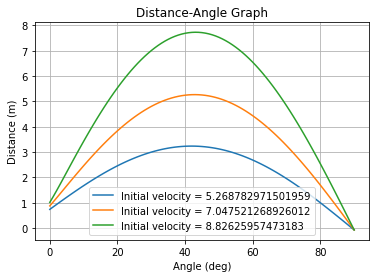

In [29]:
# initial velocities
V_mags = y
angle = np.linspace(0, 90, 91)
count=1


plt.figure(2)

xtotal=[]
for v in V_mags:
    print ('Run', count, 'of', len(V_mags))
    x=[]
    for theta in angle:
        c = distance(v, theta)
        x.append(c)
    xtotal.append(x)
    plt.plot(angle, x, label='Initial velocity = '+ str(v))
    count+=1

plt.grid(1)
plt.legend(loc='best')
plt.xlabel('Angle (deg)')
plt.ylabel('Distance (m)')
plt.title('Distance-Angle Graph')
plt.show()

### Output initial velocity and angle based on required distance

In [34]:
input_distance=[2,3,4,5,6] #INPUT TARGET DISTANCE HERE
def expected_distance(theta,v,d_1):
    y=distance(v,theta)
    return y-d_1

sol={}

for d_1 in input_distance:
    sol_1=[]
    for v_1 in V_mags:
        try:
            out_data=so.newton(expected_distance,30,args=(v_1,d_1))
            if out_data<10: ##minimum angle
                out_data=so.newton(expected_distance,60,args=(v_1,d_1))
                
            out_txt='Initial velocity of '+str(round(v_1,2))+' m/s @ '+str(round(out_data,2))+' deg'
            sol_1.append(out_txt)
            
        except:
            err_txt='Initial velocity of '+str(round(v_1,2))+': failed to reach distance'
            sol_1.append(err_txt)
            
    
    sol[d_1]=sol_1

print (sol)

{2: ['Initial velocity of 5.27 m/s @ 13.89 deg', 'Initial velocity of 7.05 m/s @ 78.18 deg', 'Initial velocity of 8.83 m/s @ 82.13 deg'], 3: ['Initial velocity of 5.27 m/s @ 30.1 deg', 'Initial velocity of 7.05 m/s @ 13.66 deg', 'Initial velocity of 8.83 m/s @ 78.13 deg'], 4: ['Initial velocity of 5.27: failed to reach distance', 'Initial velocity of 7.05 m/s @ 21.4 deg', 'Initial velocity of 8.83 m/s @ 12.51 deg'], 5: ['Initial velocity of 5.27: failed to reach distance', 'Initial velocity of 7.05 m/s @ 33.15 deg', 'Initial velocity of 8.83 m/s @ 17.2 deg'], 6: ['Initial velocity of 5.27: failed to reach distance', 'Initial velocity of 7.05: failed to reach distance', 'Initial velocity of 8.83 m/s @ 22.68 deg']}
